# DDPG algorithm in flax

In [1]:
import gymnasium as gym
import numpy as np
from collections import deque
import optax
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import jax.tree_util as jtu
from jax import random
import jax.numpy as jnp
import jax

from flax.training import train_state
from flax import linen as nn  # Linen API
from tqdm import tqdm



env = gym.make("MountainCarContinuous-v0", max_episode_steps=100)
seed = 0
key = random.PRNGKey(seed)

F_CPP_MIN_LOG_LEVEL=0
action_dim = env.action_space.shape[0]
state_dim = env.observation_space.shape[0]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Create the actor and critic model

In [2]:
#create the actor and critic newtorks like multilayer perceptrons
class Critic(nn.Module):
    """critic model MLP"""
    
    @nn.compact
    def __call__(self, observations, actions):
        x = jnp.concatenate([observations, actions], axis=-1)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return jnp.squeeze(x, axis=-1)
    
class Actor(nn.Module):
    """actor model MLP"""
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=action_dim)(x)
        x = nn.tanh(x)
        return x

## Create necessary methods to the training

In [3]:
#random process N for action exploration
def noise(noise_scale=0.1, key=key, action_dim=action_dim):
    return noise_scale * jax.random.normal(key, (action_dim,))

In [4]:
# Define the method to update model parameters

# update critic
@jax.jit
def update_critic(model, states, actions, y):
    def compute_critic_loss(params):
        Q = model.apply_fn(params, states, actions)
        return jnp.mean((Q - y)**2) #compute loss
    
    grad_fn = jax.grad(compute_critic_loss)
    grads = grad_fn(model.params)
    updated_model = model.apply_gradients(grads=grads)
    return updated_model

# udate actor
@jax.jit
def update_actor(model, states):
    def compute_actor_loss(params):
        actions = model.apply_fn(params, states)
        return -jnp.mean(actions)  # Compute the actor loss
    
    grad_fn = jax.grad(compute_actor_loss)
    grads = grad_fn(model.params)
    updated_model = model.apply_gradients(grads=grads)
    return updated_model

In [5]:
# Define the soft update function
@jax.jit
def soft_update(target_params, source_params, tau):
    # Convert the source_params to a JAX-compatible data structure
    source_params_tree = jtu.tree_map(lambda x: jnp.asarray(x), source_params)
    target_params_tree = jtu.tree_map(lambda x: jnp.asarray(x), target_params)


    # Compute the updated target parameters using a soft update
    updated_params = jtu.tree_map(lambda x, y: tau * x + (1 - tau) * y, source_params_tree, target_params_tree)

    return updated_params

## Algorithm

In [6]:
# Randomly initialize critic network Q(s, a|θ_Q ) and actor μ(s|θ_μ ) with weights θ_Q and θ_μ .
critic_params = Critic().init(key, jnp.zeros((1,action_dim)), jnp.zeros((1,state_dim)))
actor_params = Actor().init(key, jnp.zeros((1, state_dim)))

# define optimizers
actor_optimizer = optax.adam(learning_rate=100)
actor_opt_state = actor_optimizer.init(actor_params)

critic_optimizer = optax.adam(learning_rate=100)
critic_opt_state = critic_optimizer.init(critic_params)

# Initialize the training state for flax porpuses
critic = train_state.TrainState.create(
    apply_fn=Critic().apply,
    params=critic_params,
    tx=critic_optimizer
)

actor = train_state.TrainState.create(
    apply_fn=Actor().apply,
    params=actor_params,
    tx=actor_optimizer
)

print(Actor().tabulate(key, (1, state_dim) ))
print(Critic().tabulate(key, jnp.ones((1,action_dim)), jnp.ones((1,state_dim))))



                                Actor Summary                                
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs       ┃ outputs      ┃ params                   ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Actor  │ - 1          │ float32[1]   │                          │
│         │        │ - 2          │              │                          │
├─────────┼────────┼──────────────┼──────────────┼──────────────────────────┤
│ Dense_0 │ Dense  │ - 1          │ float32[256] │ bias: float32[256]       │
│         │        │ - 2          │              │ kernel: float32[2,256]   │
│         │        │              │              │                          │
│         │        │              │              │ 768 (3.1 KB)             │
├─────────┼────────┼──────────────┼──────────────┼──────────────────────────┤
│ Dense_1 │ Dense  │ float32[256] │ float32[256] │ bias: float3

In [7]:
# Initialize target network Q_0_target and μ_0_target with weights θ_Q_target ← θ_Q , θ_μ_target ← θ_μ
target_critic_params = critic_params
target_actor_params = actor_params

# Initialize the training state for flax porpuses
target_critic = train_state.TrainState.create(
    apply_fn=Critic().apply,
    params=target_critic_params,
    tx=critic_optimizer
)

target_actor = train_state.TrainState.create(
    apply_fn=Actor().apply,
    params=target_actor_params,
    tx=actor_optimizer
)

In [8]:
# Initialize replay buffer R
buffer_size = 100000
batch_size = 10

class ReplayBuffer():
    def __init__(self, buffer_size, batch_size):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.buffer = deque(maxlen=self.buffer_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample_batch(self):
        indices = jax.random.choice(key, len(self.buffer), shape=(self.batch_size,), replace=True)
        batch = [self.buffer[i] for i in indices]

        return zip(*batch)
    
buffer = ReplayBuffer(buffer_size, batch_size)


In [9]:
episodes = 30
T = 100
gamma = 0.1
tau = 0.001

env = gym.wrappers.RecordEpisodeStatistics(env)
episodes_reward = []

for i in tqdm(range(episodes)):
    # Initialize a random process N for action exploration
    N = noise(0.1)
    # Receive initial observation state s 1
    state, info = env.reset(seed=seed)
    done = False

    while not done:

        # Select action a_t = μ(s t |θ μ ) + N t according to the current policy and exploration noise
        action = noise() + actor.apply_fn(actor.params, state)

        # Execute action a t and observe reward r t and observe new state s t+1
        observation, reward, terminated, truncated, info = env.step(action)

        # Store transition (s t , a t , r t , s t+1 ) in R
        transition = (state, action, reward, observation)

        # buffer.append(transition)
        buffer.add(transition)

        # Sample a random minibatch of N transitions (s i , a i , r i , s i+1 ) from R
        states, actions, rewards, next_states = buffer.sample_batch()

        # Set y = r  + γQ^0 (s_{i+1} , μ^0 (s_{i+1} |θ^μ )|θ^Q ) P
        target_action = target_actor.apply_fn(target_actor_params, next_states)
        target_q = target_critic.apply_fn(target_critic_params, jnp.asarray(next_states), jnp.asarray(target_action))

        y = reward + gamma * (1 - terminated) * target_q

        # Update critic by minimizing the loss
        critic = update_critic(critic, jnp.asarray(states), jnp.asarray(actions), jnp.asarray(y))

        # Update the actor policy using the sampled gradient:
        actor = update_actor(actor, jnp.asarray(states))

        # Update the target networks:
        target_actor_params = soft_update(target_actor_params, actor.params, tau)
        target_critic_params = soft_update(target_critic_params, critic.params, tau)
       
        # update if the environment is done and the current observation
        done = terminated or truncated
        # state = observation


    episodes_reward.append(env.return_queue[-1])
    
    avg_reward = int(np.mean(env.return_queue))
    print("Episode:", i, "Average reward:", avg_reward)

    

env.close()

  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:13<06:27, 13.37s/it]

test
Episode: 0 Average reward: -9


  7%|▋         | 2/30 [00:22<05:04, 10.87s/it]

test
Episode: 1 Average reward: -9


 10%|█         | 3/30 [00:31<04:35, 10.19s/it]

test
Episode: 2 Average reward: -9


 13%|█▎        | 4/30 [00:41<04:15,  9.82s/it]

test
Episode: 3 Average reward: -9


 17%|█▋        | 5/30 [00:50<04:02,  9.70s/it]

test
Episode: 4 Average reward: -9


 20%|██        | 6/30 [00:59<03:50,  9.59s/it]

test
Episode: 5 Average reward: -9


 23%|██▎       | 7/30 [01:10<03:50, 10.04s/it]

test
Episode: 6 Average reward: -9


 27%|██▋       | 8/30 [01:20<03:34,  9.77s/it]

test
Episode: 7 Average reward: -9


 30%|███       | 9/30 [01:29<03:19,  9.49s/it]

test
Episode: 8 Average reward: -9


 33%|███▎      | 10/30 [01:37<03:04,  9.24s/it]

test
Episode: 9 Average reward: -9


 37%|███▋      | 11/30 [01:46<02:52,  9.07s/it]

test
Episode: 10 Average reward: -9


 40%|████      | 12/30 [01:55<02:43,  9.07s/it]

test
Episode: 11 Average reward: -9


 43%|████▎     | 13/30 [02:04<02:36,  9.18s/it]

test
Episode: 12 Average reward: -9


 47%|████▋     | 14/30 [02:17<02:41, 10.12s/it]

test
Episode: 13 Average reward: -9


 50%|█████     | 15/30 [02:27<02:31, 10.11s/it]

test
Episode: 14 Average reward: -9


 53%|█████▎    | 16/30 [02:36<02:16,  9.78s/it]

test
Episode: 15 Average reward: -9


 57%|█████▋    | 17/30 [02:46<02:08,  9.89s/it]

test
Episode: 16 Average reward: -9


 60%|██████    | 18/30 [02:55<01:56,  9.74s/it]

test
Episode: 17 Average reward: -9


 63%|██████▎   | 19/30 [03:05<01:45,  9.60s/it]

test
Episode: 18 Average reward: -9


 67%|██████▋   | 20/30 [03:14<01:34,  9.46s/it]

test
Episode: 19 Average reward: -9


 70%|███████   | 21/30 [03:23<01:24,  9.39s/it]

test
Episode: 20 Average reward: -9


 73%|███████▎  | 22/30 [03:32<01:14,  9.34s/it]

test
Episode: 21 Average reward: -9


 77%|███████▋  | 23/30 [03:41<01:05,  9.29s/it]

test
Episode: 22 Average reward: -9


 80%|████████  | 24/30 [03:51<00:56,  9.37s/it]

test
Episode: 23 Average reward: -9


 83%|████████▎ | 25/30 [04:00<00:47,  9.41s/it]

test
Episode: 24 Average reward: -9


 87%|████████▋ | 26/30 [04:09<00:37,  9.31s/it]

test
Episode: 25 Average reward: -9


 90%|█████████ | 27/30 [04:19<00:27,  9.25s/it]

test
Episode: 26 Average reward: -9


 93%|█████████▎| 28/30 [04:28<00:18,  9.19s/it]

test
Episode: 27 Average reward: -9


 97%|█████████▋| 29/30 [04:37<00:09,  9.15s/it]

test
Episode: 28 Average reward: -9


100%|██████████| 30/30 [04:46<00:00,  9.55s/it]

test
Episode: 29 Average reward: -9


## Visualizing the training

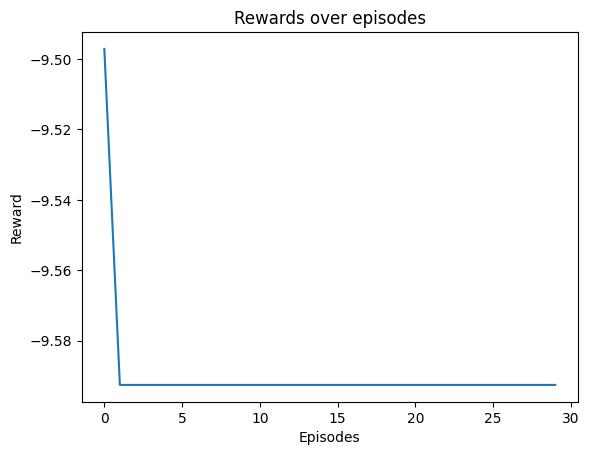

In [13]:
rewards_to_plot = [rewards for rewards in episodes_reward]

plt.plot(range(episodes), episodes_reward)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Rewards over episodes')
plt.show()

## Stable baselines training

In [11]:
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise

In [12]:
# The noise objects for DDPG
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)
model.learn(total_timesteps=10000, log_interval=10)
model.save("ddpg_MountainCarContinuous")
vec_env = model.get_env()

del model # remove to demonstrate saving and loading

model = DDPG.load("ddpg_MountainCarContinuous")

obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    env.render("human")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -0.429   |
| time/              |          |
|    episodes        | 10       |
|    fps             | 66       |
|    time_elapsed    | 14       |
|    total_timesteps | 1000     |
| train/             |          |
|    actor_loss      | 0.0379   |
|    critic_loss     | 4.14e-08 |
|    learning_rate   | 0.001    |
|    n_updates       | 800      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -0.264   |
| time/              |          |
|    episodes        | 20       |
|    fps             | 57       |
|    time_elapsed    | 34       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 0.0358   |
|    critic_loss     |

TypeError: Wrapper.render() takes 1 positional argument but 2 were given